# Introduction

This notebook is based on [yu_roger-10906675-week1_randcv_xgb_69051.ipynb](https://github.com/roger-yu-ds/assignment_1/blob/roger/notebooks/yu_roger-10906675-week1_randcv_xgb_69051.ipynb), which achieved 0.69051 AUC on the test set in Kaggle.

## Early Stopping
The purpose of this notebook is to investigate the improvement in the model when the model uses [early stopping](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/), i.e. stops the training when the metric on the validation set stops to improve.

## Limited Features
Another goal of this notebook is to limit the features and calculate the validation AUC.

## Summary
* [Early stopping](#Conclusion:-early-stopping) has reduced overfitting and increased the validation AUC from 0.660 to 0.687.
* [Feature selection](#Conclusion:-feature-importance) according to the top 8 feature importance (by gain) has also reduced overfitting as can be seen by the more similar train AUC and validation AUC of 0.743 and 0.685, respectively.
* The predictions are heavily weighted to the positive class, with almost no predictions in the negative class.

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import find_dotenv, load_dotenv
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

from src.data import make_dataset
from src.models.null import NullModel
from src.visualization.visualize import classification_reports, classification_reports_2
from src.visualization.visualize import plot_pie, create_feature_importance_df, plot_feature_importances


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
load_dotenv(find_dotenv())
api = KaggleApi()
api.authenticate()

In [5]:
competition = os.environ['COMPETITION']

# Set up directories

In [9]:
project_dir = Path.cwd().parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

# Load data

In [11]:
X_train, X_val, y_train, y_val, X_test = make_dataset.load_sets(interim_data_dir)
test_id = pd.read_csv(interim_data_dir / 'test_id.csv')

# Baseline

The base line prediction is simply to make them all negative.

In [12]:
(y_train.values == 1).sum()

5332

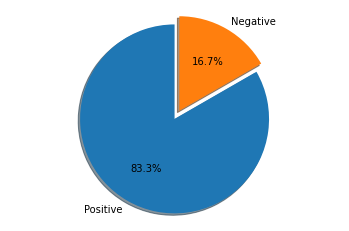

In [13]:
labels = 'Positive', 'Negative'
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
sizes = [pos_count, neg_count]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [14]:
pd.Series(y_train).value_counts(normalize=True)

1    0.833125
0    0.166875
Name: TARGET_5Yrs, dtype: float64

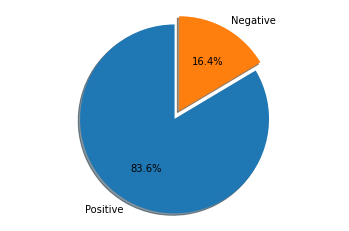

In [15]:
labels = 'Positive', 'Negative'
pos_count = (y_val.values == 1).sum()
neg_count = (y_val.values == 0).sum()
sizes = [pos_count, neg_count]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Baseline Score

The baseline score is to merely predict the larger class for all instances of the training set.

In [16]:
null_model = NullModel(target_type='classification')
roc_auc_score(y_val, null_model.fit_predict(y_val))

0.5

# Naive XGB

In [17]:
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [18]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[ 886  182]
 [   0 5332]]
Accuracy:  0.9715625
AUC:  0.9991016012430074
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      1068
           1       0.97      1.00      0.98      5332

    accuracy                           0.97      6400
   macro avg       0.98      0.91      0.95      6400
weighted avg       0.97      0.97      0.97      6400



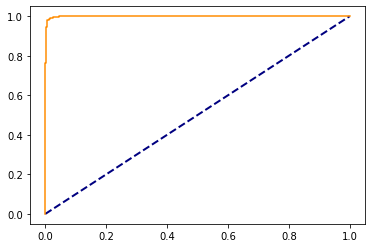

In [19]:
classification_reports(clf, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[  25  238]
 [  56 1281]]
Accuracy:  0.81625
AUC:  0.6601664813398136
              precision    recall  f1-score   support

           0       0.31      0.10      0.15       263
           1       0.84      0.96      0.90      1337

    accuracy                           0.82      1600
   macro avg       0.58      0.53      0.52      1600
weighted avg       0.76      0.82      0.77      1600



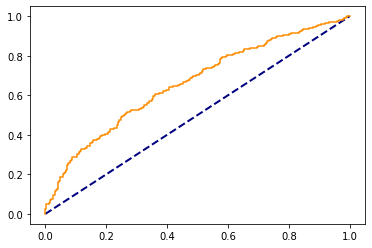

In [20]:
classification_reports(clf, X_val, y_val)

# Early Stopping

## Visualise AUC per iteration

In [21]:
clf_es = xgb.XGBClassifier(use_label_encoder=False, 
                        eval_metric='logloss')
clf_es.fit(X_train,
           y_train,
           eval_metric='auc',
           eval_set=[(X_val, y_val), (X_train, y_train)],
#            early_stopping_rounds=5,
           verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

<Figure size 2160x720 with 0 Axes>

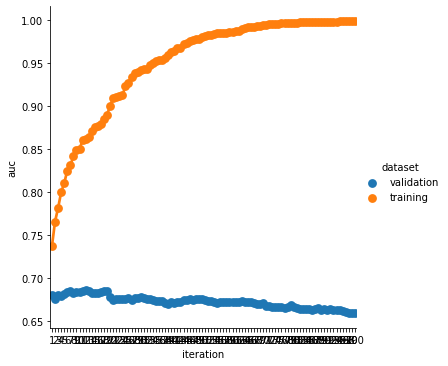

In [22]:
eval_scores = clf_es.evals_result_['validation_0']['auc']

scores_df = pd.DataFrame({'iteration': range(1, len(eval_scores) + 1),
                          'validation': clf_es.evals_result_['validation_0']['auc'],
                          'training': clf_es.evals_result_['validation_1']['auc']}) 

plot_df = scores_df.melt(id_vars='iteration',
                         var_name='dataset',
                         value_name='auc')

plt.figure(figsize=(30, 10))
sns.catplot(x='iteration',
            y='auc',
            hue='dataset',
            data=plot_df,
            kind='point')



The AUC on the validation set decreases after the first few iterations, while the training auc continues to increase.

In [23]:
# Redo the fitting without the training set, otherwise the algorithm will take the best of the two scores.
clf_es.fit(X_train,
           y_train,
           eval_metric='auc',
           eval_set=[(X_val, y_val)],
           early_stopping_rounds=10,
           verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [24]:
best_iteration = clf_es.get_booster().best_iteration
best_iteration

11

In [25]:
best_ntree_limit = clf_es.get_booster().best_ntree_limit
best_ntree_limit

12

In [26]:
preds_train = clf_es.predict(X_train, ntree_limit=best_ntree_limit)
probs_train = clf_es.predict_proba(X_train, ntree_limit=best_ntree_limit)[:, 1]
preds_val = clf_es.predict(X_val, ntree_limit=best_ntree_limit)
probs_val = clf_es.predict_proba(X_val, ntree_limit=best_ntree_limit)[:, 1]

## Training results

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[ 160  908]
 [  14 5318]]
Accuracy:  0.8559375
AUC:  0.8623901937563043
              precision    recall  f1-score   support

           0       0.92      0.15      0.26      1068
           1       0.85      1.00      0.92      5332

    accuracy                           0.86      6400
   macro avg       0.89      0.57      0.59      6400
weighted avg       0.87      0.86      0.81      6400



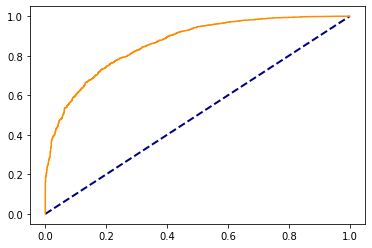

In [27]:
classification_reports_2(y_train, preds_train, probs_train, verbose=False)


## Validation results

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[  13  250]
 [  19 1318]]
Accuracy:  0.831875
AUC:  0.6868379067829629
              precision    recall  f1-score   support

           0       0.41      0.05      0.09       263
           1       0.84      0.99      0.91      1337

    accuracy                           0.83      1600
   macro avg       0.62      0.52      0.50      1600
weighted avg       0.77      0.83      0.77      1600



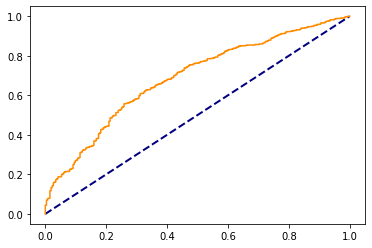

In [28]:
classification_reports_2(y_val, preds_val, probs_val, verbose=False)

## Conclusion: early stopping

Early stopping improves the results slightly; from 0.660 to 0.687.

# Feature importance

The training AUC is much higher than the validation AUC, which indicates that the model is overfit. One way to reduce overfitting is to reduce the number of features. In this section, the feature importances will be investigated and another model will be trained using just the top features.

In [29]:
importance_df = create_feature_importance_df(clf_es,
                                             X_train.columns)
importance_df.head()

,feature,score,importance_type
0,GP,11.643813,gain
1,FG%,4.515233,gain
2,OREB,4.341428,gain
3,3P Made,3.033622,gain
4,FT%,3.451736,gain


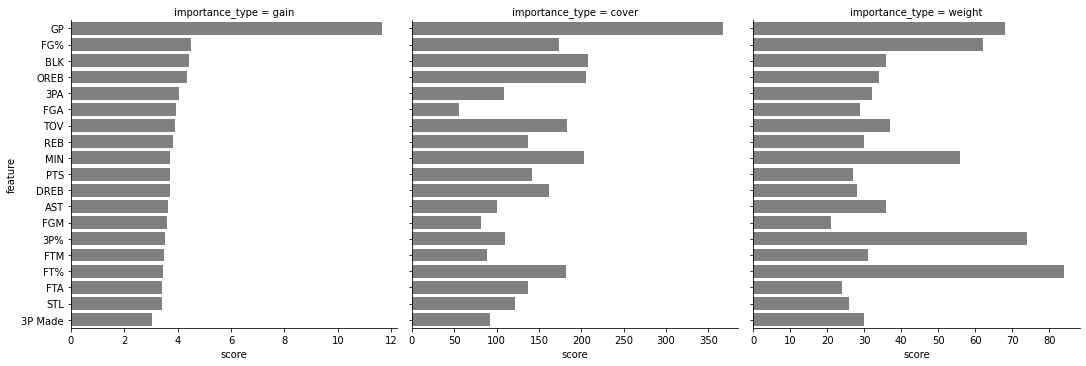

In [30]:
plot_feature_importances(importance_df)

# Early stopping and limited features

Take the top 8 features by the **gain** score and fit another XGB Classifier model.

In [31]:
features = (
    importance_df
    .query('importance_type == "gain"')
    .sort_values(by=['score'])
    .loc[:8, 'feature']
    .to_list()
)

X_train_lim = X_train[features]
X_val_lim = X_val[features]

clf_limited = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

clf_limited.fit(X_train_lim,
                y_train,
                eval_metric='auc',
                eval_set=[(X_val_lim, y_val)],
                early_stopping_rounds=10,
                verbose=False)

best_ntree_limit = clf_limited.get_booster().best_ntree_limit
best_iteration = clf_limited.get_booster().best_iteration

print(f'best_ntree_limit: {best_ntree_limit}')

best_ntree_limit: 4


 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  66 1002]
 [  13 5319]]
Accuracy:  0.84140625
AUC:  0.7433892356516094
              precision    recall  f1-score   support

           0       0.84      0.06      0.12      1068
           1       0.84      1.00      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.84      0.53      0.51      6400
weighted avg       0.84      0.84      0.78      6400



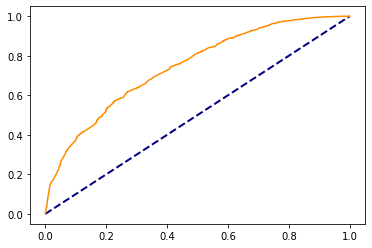

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   8  255]
 [   8 1329]]
Accuracy:  0.835625
AUC:  0.6846865037496694
              precision    recall  f1-score   support

           0       0.50      0.03      0.06       263
           1       0.84      0.99      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.67      0.51      0.48      1600
weighted avg       0.78      0.84      0.77      1600



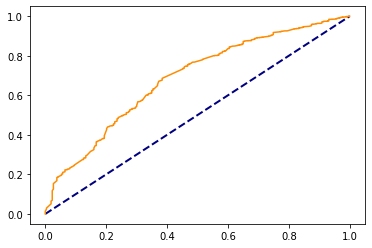

In [32]:
preds_train = clf_limited.predict(X_train_lim, ntree_limit=best_ntree_limit)
probs_train = clf_limited.predict_proba(X_train_lim, ntree_limit=best_ntree_limit)[:, 1]
preds_val = clf_limited.predict(X_val_lim, ntree_limit=best_ntree_limit)
probs_val = clf_limited.predict_proba(X_val_lim, ntree_limit=best_ntree_limit)[:, 1]

classification_reports_2(y_train, preds_train, probs_train)
classification_reports_2(y_val, preds_val, probs_val)

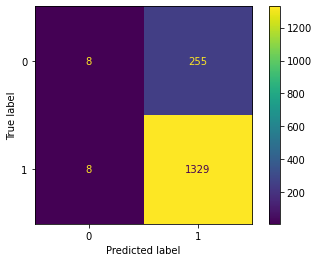

In [35]:
plot_confusion_matrix(clf_limited,X_val_lim, y_val)

## Conclusion: feature importance

Limiting the features to just the top 8 seems to have produced a similarly high validation AUC of 0.685. The predictions are heavily weighted to the positive class, with almost no predictions in the negative class.

## Save data

In [70]:
location = interim_data_dir
suffix = 'top_8_features'
make_dataset.save_sets(X_train_lim, 
                       X_val_lim,
                       y_train,
                       y_val,
                       X_test_lim,
                       location,
                       suffix,
                       file_type = 'csv') 

## Save model

In [71]:
dump(clf_limited, models_dir / 'xgb_top_8_features_early_stopping.joblib')

['D:\\Projects\\assignment_1\\models\\xgb_top_8_features_early_stopping.joblib']

# Submit predictions

In [82]:
X_test_lim = X_test[features]
preds = clf_limited.predict(X_test_lim)
probs = clf_limited.predict_proba(X_test_lim)[:, 1]

In [87]:
pred_path = processed_data_dir / 'preds_xgb_early_stop_8_features.csv'
pred_name = 'TARGET_5Yrs'
make_dataset.save_predictions(probs, pred_name, test_id, pred_path)